In [102]:
import networkx as nx
import pandas as pd
import numpy as np

In [103]:
training_df = pd.read_csv('data/training_data.csv', low_memory=False)


In [104]:
# convert ratios into numeric

cols_to_convert = ['governor_contribution_ratio', 'senate_contribution_ratio', 'us_senate_contribution_ratio']
for col in cols_to_convert:
    training_df[col] = pd.to_numeric(training_df[col], errors='coerce')

# Extract Features

In [ ]:
training_df = training_df[training_df["zip_code"].notna()]
training_df["zip_code"] = training_df["zip_code"].astype(int).astype(str).str.zfill(5)

In [107]:
zip_df = pd.read_csv('data/uszips.csv')
zip_df['zip'] = zip_df['zip'].astype(str).str.zfill(5)

In [111]:
# TODO: use zip code specific information to get geographic and demographic data 

In [113]:
# use zip code to fill city and state wherever empty
# use this mapper
zip_df

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,00601,18.18027,-66.75266,Adjuntas,PR,Puerto Rico,True,NaN,16721.0,100.2,72001,Adjuntas,"{""72001"": 98.74, ""72141"": 1.26}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,00602,18.36075,-67.17541,Aguada,PR,Puerto Rico,True,NaN,37510.0,477.6,72003,Aguada,"{""72003"": 100}",Aguada,72003,False,False,America/Puerto_Rico
2,00603,18.45744,-67.12225,Aguadilla,PR,Puerto Rico,True,NaN,48317.0,543.1,72005,Aguadilla,"{""72005"": 99.76, ""72099"": 0.24}",Aguadilla|Moca,72005|72099,False,False,America/Puerto_Rico
3,00606,18.16585,-66.93716,Maricao,PR,Puerto Rico,True,NaN,5435.0,47.3,72093,Maricao,"{""72093"": 82.27, ""72153"": 11.66, ""72121"": 6.06}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,00610,18.29110,-67.12243,Anasco,PR,Puerto Rico,True,NaN,25413.0,264.4,72011,Añasco,"{""72011"": 96.71, ""72099"": 2.82, ""72083"": 0.37,...",Añasco|Moca|Las Marías|Aguada,72011|72099|72083|72003,False,False,America/Puerto_Rico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33778,99923,55.98043,-130.03803,Hyder,AK,Alaska,True,NaN,25.0,0.6,2198,Prince of Wales-Hyder,"{""02198"": 100}",Prince of Wales-Hyder,02198,False,False,America/Sitka
33779,99925,55.55398,-132.96276,Klawock,AK,Alaska,True,NaN,854.0,6.1,2198,Prince of Wales-Hyder,"{""02198"": 100}",Prince of Wales-Hyder,02198,False,False,America/Sitka
33780,99926,55.12617,-131.48928,Metlakatla,AK,Alaska,True,NaN,1385.0,4.0,2198,Prince of Wales-Hyder,"{""02198"": 100}",Prince of Wales-Hyder,02198,False,False,America/Metlakatla
33781,99927,56.33305,-133.60044,Point Baker,AK,Alaska,True,NaN,18.0,1.5,2198,Prince of Wales-Hyder,"{""02198"": 100}",Prince of Wales-Hyder,02198,False,False,America/Sitka


# EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
# checking for missing values
missing_summary = training_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_summary / len(training_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_summary,
    'Percentage (%)': missing_percent
})

print(missing_df[missing_df['Missing Values'] > 0])

                                       Missing Values  Percentage (%)
us_senate_contribution_ratio                      193        0.111659
senate_contribution_ratio                         193        0.111659
governor_contribution_ratio                       193        0.111659
us_house_contribution_ratio                       192        0.111080
house_and_assembly_contribution_ratio             192        0.111080


In [670]:
training_df.dropna(inplace=True)

In [ ]:
#                                      Missing Values  Percentage (%)
#zip_code                                         3929        2.273095
#city                                             1468        0.849301
#senate_contribution_ratio                         193        0.111659
#governor_contribution_ratio                       193        0.111659
#us_senate_contribution_ratio                      193        0.111659
#us_house_contribution_ratio                       192        0.111080
#house_and_assembly_contribution_ratio             192        0.111080

In [ ]:
# experimental features - may no be needed if we have some zip information
training_df["party_bias_score"] = training_df["contribution_democratic_count_ratio"] - training_df["contribution_republican_count_ratio"]
training_df["candidate_party_bias_score"] = training_df["candidacy_democratic_ratio"] - training_df["candidacy_republican_ratio"]
training_df["avg_contrib_size"] = training_df["contribution_sum_2010_usd"] / (training_df["contribution_count"] + 1)
training_df["candidate_diversity"] = training_df["politician_count"] / (training_df["contribution_count"] + 1)
training_df["incumbency_loyalty"] = training_df["politician_incumbency_count"] / (training_df["politician_count"] + 1)

training_df["gov_focus"] = training_df["governor_contributions_sum_2010_usd"] / (training_df["contribution_sum_2010_usd"] + 1e-5)
training_df["senate_focus"] = training_df["senate_contributions_sum_2010_usd"] / (training_df["contribution_sum_2010_usd"] + 1e-5)
training_df["house_focus"] = training_df["house_and_assembly_contributions_sum_2010_usd"] / (training_df["contribution_sum_2010_usd"] + 1e-5)
training_df["us_house_focus"] = training_df["us_house_contributions_sum_2010_usd"] / (training_df["contribution_sum_2010_usd"] + 1e-5)
training_df["us_senate_focus"] = training_df["us_senate_contributions_sum_2010_usd"] / (training_df["contribution_sum_2010_usd"] + 1e-5)


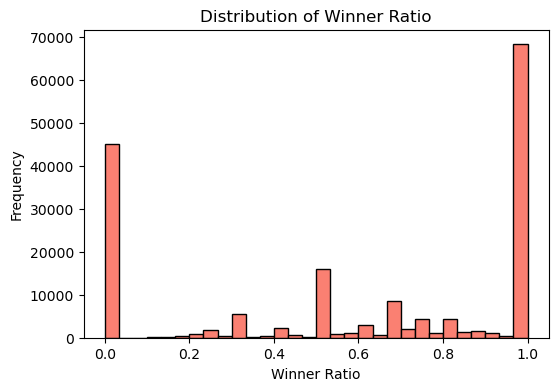

In [ ]:
# looking at target variabke
import matplotlib.pyplot as plt
#histogram
plt.figure(figsize=(6, 4))  
plt.hist(training_df['winner_ratio'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Winner Ratio')
plt.xlabel('Winner Ratio')
plt.ylabel('Frequency')
plt.show()

Bimodal distribution. I'm thinking this distribution suggests that contributors might be influenced by their networks or have a party preference - the winning or the losing.

In [ ]:
# features to look at 
num_features = training_df.select_dtypes(include=np.number).columns.drop('winner_ratio')
cat_features = training_df.select_dtypes(include='object').columns

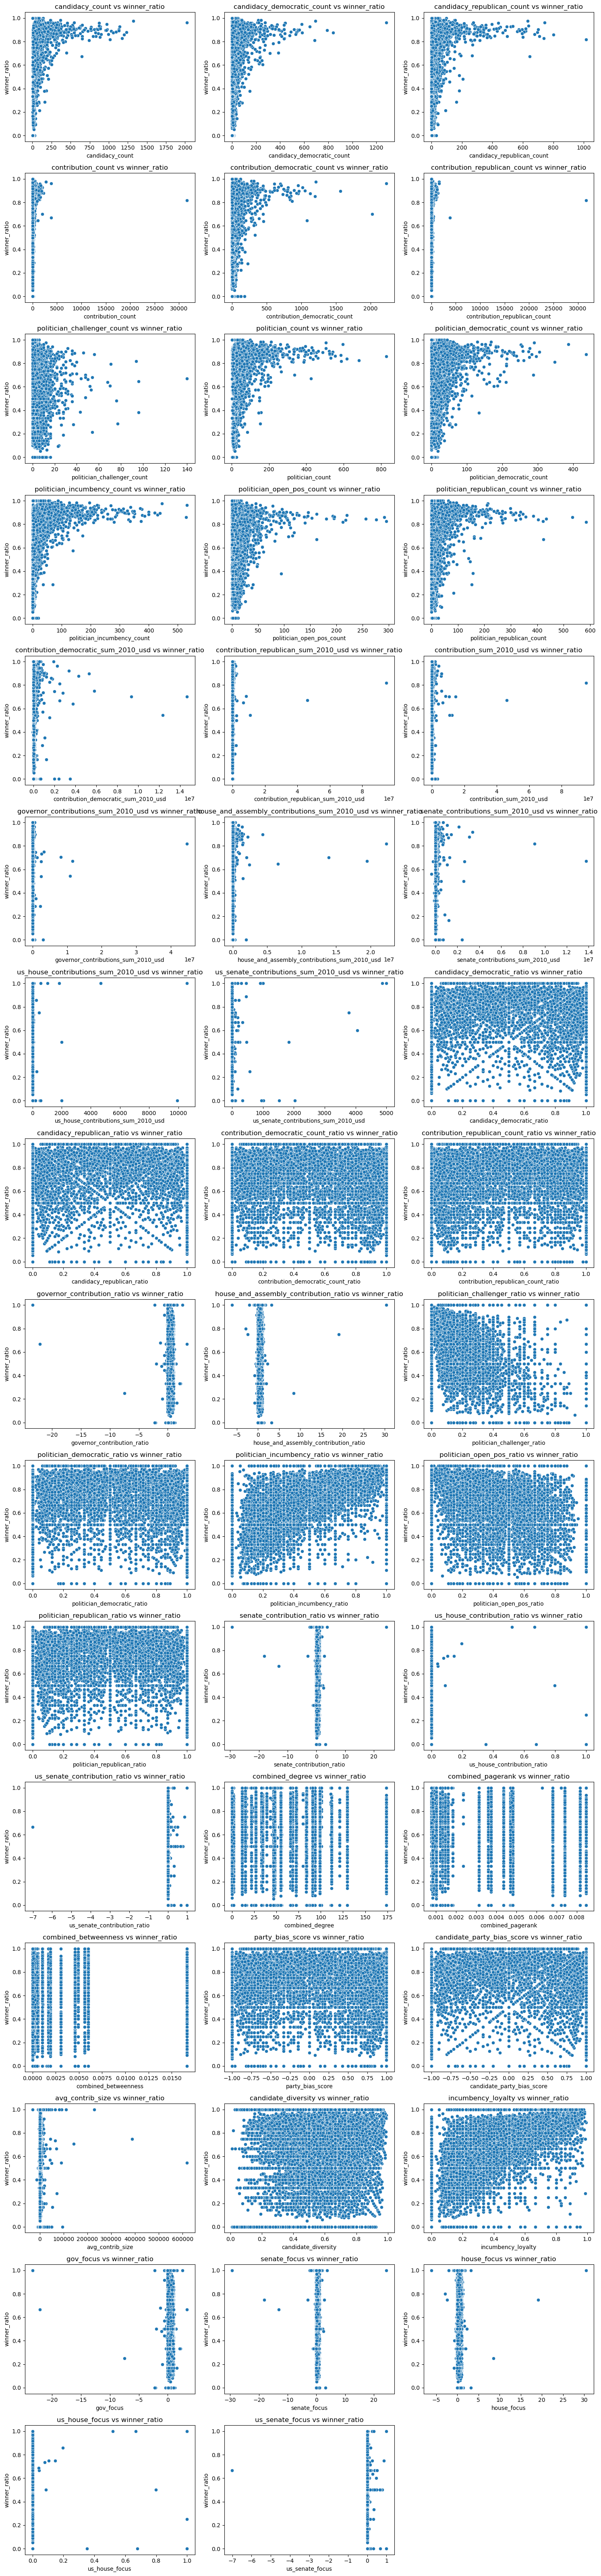

In [ ]:
cols = 3
rows = math.ceil(len(num_features) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  # flatten to make indexing easier

for i, feature in enumerate(num_features):
    sns.scatterplot(x=training_df[feature], y=training_df['winner_ratio'], ax=axes[i])
    axes[i].set_title(f'{feature} vs winner_ratio')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('winner_ratio')

# Turn off unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<span style="color:red"><b><<<<<<< local</b></span>

- investing in more condidates (democratic or republican) does seem to result in higher winner_ratio
- contributors who invest in more candidates of a specific party tend to have a higher sucess within that party's cadidates 
- contribution_democratic_sum_2010_usd vs winner_ratio: contributors who donate more money to Democrats might be better at backing winners within that party, or perhaps larger donations have a greater impact on a candidate's success.
- candidacy_democratic_ratio & candidacy_republican_ratio: non-linear relationship between the partisan focus of investments and the winner_ratio
- senate_contribution_ratio and us_house_contribution_ratio: Due to the clustering around zero and the wide spread of winner_ratio at these low values, these ratios might have a weaker direct predictive power for the majority of contributors. However:
    - For the small subset of contributors with higher ratios, these features might be more important. Consider creating binary features (e.g., "significant_senate_contributor" if senate_contribution_ratio > some threshold) or interaction terms with other features.
    - The fact that most contributors allocate little to these specific levels could itself be a signal.

### Looking at mutual information
Mutual information measures the statistical dependence between two random variables. Unlike correlation, it can capture both linear and non-linear relationships.

In [18]:
correlations = training_df[num_features.tolist() + ['winner_ratio']].corr()['winner_ratio'].sort_values(ascending=False)
print("Correlations with winner_ratio:\n", correlations)

Correlations with winner_ratio:
 winner_ratio                                     1.000000
politician_incumbency_ratio                      0.510384
politician_incumbency_count                      0.112160
house_and_assembly_contribution_ratio            0.086107
senate_contribution_ratio                        0.082174
politician_count                                 0.060162
politician_republican_count                      0.058870
candidacy_count                                  0.057109
candidacy_republican_count                       0.055196
candidacy_democratic_count                       0.045845
politician_democratic_count                      0.044284
contribution_democratic_count                    0.023183
contribution_count                               0.022011
contribution_republican_count_ratio              0.018260
candidacy_republican_ratio                       0.018219
politician_republican_ratio                      0.018110
us_house_contributions_sum_2010_usd    

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression


In [22]:
# For numerical features
mi_scores_numerical = mutual_info_regression(training_df[num_features], training_df['winner_ratio'], random_state=42)
mi_scores_numerical = pd.Series(mi_scores_numerical, index=num_features).sort_values(ascending=False)
print("\nMutual Information (Numerical Features):\n", mi_scores_numerical)


Mutual Information (Numerical Features):
 candidacy_count                                  0.864452
politician_incumbency_ratio                      0.558572
politician_count                                 0.541000
politician_open_pos_ratio                        0.428522
contribution_count                               0.401987
politician_incumbency_count                      0.355032
politician_challenger_ratio                      0.350790
candidacy_democratic_count                       0.324079
contribution_sum_2010_usd                        0.292600
politician_democratic_count                      0.250578
candidacy_democratic_ratio                       0.232847
candidacy_republican_ratio                       0.230981
politician_open_pos_count                        0.228143
candidacy_republican_count                       0.217733
politician_republican_count                      0.182914
contribution_democratic_count                    0.167873
politician_republican_ratio  

In [23]:
# For categorical features (need encoding)
if len(cat_features) > 0:
    label_encoders = {}
    train_df_encoded_cat = pd.DataFrame()

    for col in cat_features:
        # Convert entire column to string to ensure uniformity
        col_data = training_df[col].astype(str)
        le = LabelEncoder()
        train_df_encoded_cat[col] = le.fit_transform(col_data)
        label_encoders[col] = le

mi_scores_categorical = mutual_info_regression(train_df_encoded_cat, training_df['winner_ratio'], random_state=42)
mi_scores_categorical = pd.Series(mi_scores_categorical, index=cat_features).sort_values(ascending=False)
print("\nMutual Information (Categorical Features):\n", mi_scores_categorical)


Mutual Information (Categorical Features):
 zip_code            0.078399
state               0.077061
city                0.052558
specific_sector     0.043145
general_sector      0.039192
contributor_type    0.016879
dtype: float64


Analysis of correlations:
- Strong Positive Correlation: `politician_incumbency_ratio` stands out with a moderate positive correlation (0.51).
- Moderate Negative Correlation: `politician_challenger_ratio` (-0.336), `politician_open_pos_ratio` (-0.257), and `governor_contribution_ratio` (-0.143) show moderate negative correlations. This suggests that higher investment in challengers and open positions, and higher giving to governor races are associated with a lower `winner_ratio`.
- Other featuers are weaker but the relationship with `winner_ratio` might be non-linear or might interact more w other features.


<span style="color:red"><b>=======</b></span>

# Try Modelling

In [675]:
X = training_df.copy()
y = X['winner_ratio']
X.drop('winner_ratio', axis=1, inplace=True)

In [676]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [677]:
import category_encoders as ce
#!pip install category_encoders #uncomment if library not found error

In [678]:
target_enc_cols = ['city', 'specific_sector']
target_encoder = ce.TargetEncoder(cols=target_enc_cols)
X_train[target_enc_cols] = target_encoder.fit_transform(X_train[target_enc_cols], y_train)
X_test[target_enc_cols] = target_encoder.transform(X_test[target_enc_cols])

# Use OneHotEncoder for low cardinality
onehot_cols = ['general_sector', 'state', 'contributor_type']
onehot_encoder = ce.OneHotEncoder(cols=onehot_cols, use_cat_names=True)
X_train = onehot_encoder.fit_transform(X_train)
X_test = onehot_encoder.transform(X_test)

## Benchmark

In [679]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [680]:
xgb_model = XGBRegressor(objective='reg:squarederror', 
    n_estimators=500,              # number of boosting rounds
    learning_rate=0.08,            # step size shrinkage
    max_depth=12,
    min_child_weight = 1,             
    reg_lambda=0.01,                
    random_state=42)


xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse}")


XGBoost MSE: 0.07935038115955231


# import test data

In [681]:
# import test data
test = pd.read_csv('data/test_data.csv')

In [682]:
cols_to_convert = ['governor_contribution_ratio', 'senate_contribution_ratio', 'us_senate_contribution_ratio']
for col in cols_to_convert:
    test[col] = pd.to_numeric(test[col], errors='coerce')

test['city'] = test['city'].fillna('Unknown')
test['zip_code'] = test['zip_code'].fillna("00000")
test['zip_code'] = test['zip_code'].astype(int)

# test['agi_stub'] = test['zip_code'].map(agi_mode_by_zip)

test["party_bias_score"] = test["contribution_democratic_count_ratio"] - test["contribution_republican_count_ratio"]
test["candidate_party_bias_score"] = test["candidacy_democratic_ratio"] - test["candidacy_republican_ratio"]
test["avg_contrib_size"] = test["contribution_sum_2010_usd"] / (test["contribution_count"] + 1)
test["candidate_diversity"] = test["politician_count"] / (test["contribution_count"] + 1)
test["incumbency_loyalty"] = test["politician_incumbency_count"] / (test["politician_count"] + 1)

test["gov_focus"] = test["governor_contributions_sum_2010_usd"] / (test["contribution_sum_2010_usd"] + 1e-5)
test["senate_focus"] = test["senate_contributions_sum_2010_usd"] / (test["contribution_sum_2010_usd"] + 1e-5)
test["house_focus"] = test["house_and_assembly_contributions_sum_2010_usd"] / (test["contribution_sum_2010_usd"] + 1e-5)
test["us_house_focus"] = test["us_house_contributions_sum_2010_usd"] / (test["contribution_sum_2010_usd"] + 1e-5)
test["us_senate_focus"] = test["us_senate_contributions_sum_2010_usd"] / (test["contribution_sum_2010_usd"] + 1e-5)

test.drop('winner_ratio', axis=1,inplace=True)

target_enc_cols = ['city', 'specific_sector']
test[target_enc_cols] = target_encoder.transform(test[target_enc_cols])

onehot_cols = ['general_sector', 'state', 'contributor_type']
test = onehot_encoder.transform(test)

In [683]:
preds = pd.DataFrame(data=xgb_model.predict(test), index=test.index)

In [684]:
preds.index.rename('index', inplace=True)
preds.rename(columns={0:'winner_ratio'}, inplace=True)

In [685]:
preds['winner_ratio'].describe()

count    115232.000000
mean          0.592403
std           0.310057
min          -0.390542
25%           0.375639
50%           0.639089
75%           0.857339
max           1.332727
Name: winner_ratio, dtype: float64

In [687]:
preds.to_csv('data/preds_unscaled.csv')

# ignore

In [109]:
# ignore


# kinda useless: 
# winning_bipartite_df = pd.read_csv('data/winning_candidates_state_bipartite_weighted_network.csv')
# state_df = pd.read_csv('data/state_contributor_top100_contributors_network.csv', index_col='Unnamed: 0')
# fed_df = pd.read_csv('data/federal_contributor_top100_contributors_network.csv', index_col= 'Unnamed: 0')
# all_bipartite_df = pd.read_csv('data/all_candidates_state_bipartite_weighted_network.csv')
# #! weird : negative and inf values in ratio columns - i am dropping them
# ratio_cols = [col for col in training_df.columns if 'ratio' in col and col!='winner_ratio']
# training_df[ratio_cols] = training_df[ratio_cols].replace([np.inf, -np.inf], np.nan)   
# training_df = training_df[(training_df[ratio_cols].ge(0).all(axis=1))&(training_df[ratio_cols].le(1).all(axis=1))]  #rows where all numeric values are >= 0
# training_df = training_df.dropna(subset=ratio_cols)
# training_df
# # uncomment when running for the first time
# all_bipartite_df.drop('Unnamed: 1', axis=1, inplace=True)
# winning_bipartite_df.drop('Unnamed: 1', axis=1, inplace=True)
# all_bipartite_df.rename(columns={'Unnamed: 0':'Name'},  inplace=True)
# winning_bipartite_df.rename(columns={'Unnamed: 0':'Name'},   inplace=True)
# all_bipartite_df.set_index('Name', inplace=True)
# winning_bipartite_df.set_index('Name', inplace=True)
# # each graph is a bipartite graph that shows amount of money contributed to each state - one as to all candidates of that state
# # and the other winning candidates of the state

# #get the states where contributors donated the most to
# all_bipartite_df['highest_contributing_state'] = all_bipartite_df.columns[np.argmax(all_bipartite_df, axis=1)]
# winning_bipartite_df['highest_contributing_state'] = winning_bipartite_df.columns[np.argmax(winning_bipartite_df, axis=1)]
# def create_bipartite_graph(df):
#     B = nx.Graph()
#     df = df.select_dtypes(include='number')
    
#     for index, row in df.iterrows():
#         for column in df.columns:
#             if row[column] > 0:  # sent some money
#                 B.add_edge(index, column, weight=row[column])
#     return B

# winning_graph = create_bipartite_graph(winning_bipartite_df)
# all_candidates_graph = create_bipartite_graph(all_bipartite_df)

# # Create graphs for the state and federal contributor networks (adjacency matrices)
# state_contributor_graph = nx.from_pandas_adjacency(state_df)
# federal_contributor_graph = nx.from_pandas_adjacency(fed_df)
# import re

# def parse_contributor_metadata(node_name):
#     """
#     Extract city, zip, and state from the end of a node string like:
#     'MCGUIRE, PERRY J DOUGLASVILLE 30135 GA'
#     """
#     tokens = node_name.strip().split()
#     if len(tokens) >= 3:
#         state = tokens[-1].upper()
#         zip_code = tokens[-2]
#         city = tokens[-3].title()
#         return city, zip_code, state
#     else:
#         return None, None, None

# def extract_network_features_with_location(G, label="state"):
#     # Compute network stats
#     degree = dict(G.degree())
#     betweenness = nx.betweenness_centrality(G)
#     pagerank = nx.pagerank(G)

#     rows = []
#     for node in G.nodes:
#         city, zip_code, state = parse_contributor_metadata(node)
#         rows.append({
#             "city": city,
#             "zip_code": zip_code,
#             "state": state,
#             f"{label}_degree": degree.get(node, 0),
#             f"{label}_betweenness": betweenness.get(node, 0),
#             f"{label}_pagerank": pagerank.get(node, 0)
#         })

#     return pd.DataFrame(rows)

# state_net_df = extract_network_features_with_location(state_contributor_graph, label="state")
# federal_net_df = extract_network_features_with_location(federal_contributor_graph, label="federal")
# state_net_zip_agg = state_net_df.groupby("zip_code")[["state_degree", "state_betweenness", "state_pagerank"]].mean().reset_index()
# federal_net_state_agg = federal_net_df.groupby("state")[["federal_degree", "federal_betweenness", "federal_pagerank"]].mean().reset_index()

# def map_combined_graph_feature(training_df, state_df, federal_df, feature_name):

#     def hierarchical_feature_map(row, zip_dict, city_dict, state_dict):
#         zip_code = str(row['zip_code']).strip()
#         city = str(row['city']).strip().upper()
#         state = str(row['state']).strip().upper()

#         if zip_code in zip_dict:
#             return zip_dict[zip_code]
#         elif city in city_dict:
#             return city_dict[city]
#         elif state in state_dict:
#             return state_dict[state]
#         else:
#             return np.nan

#     # --- STATE SOURCE ---
#     zip_dict_s = state_df.set_index('zip_code')[f'state_{feature_name}'].dropna().to_dict()
#     city_dict_s = state_df.set_index('city')[f'state_{feature_name}'].dropna().to_dict()
#     state_dict_s = state_df.set_index('state')[f'state_{feature_name}'].dropna().to_dict()

#     training_df[f'state_{feature_name}_mapped'] = training_df.apply(
#         lambda row: hierarchical_feature_map(row, zip_dict_s, city_dict_s, state_dict_s),
#         axis=1
#     )

#     # --- FEDERAL SOURCE ---
#     zip_dict_f = federal_df.set_index('zip_code')[f'federal_{feature_name}'].dropna().to_dict()
#     city_dict_f = federal_df.set_index('city')[f'federal_{feature_name}'].dropna().to_dict()
#     state_dict_f = federal_df.set_index('state')[f'federal_{feature_name}'].dropna().to_dict()

#     training_df[f'federal_{feature_name}_mapped'] = training_df.apply(
#         lambda row: hierarchical_feature_map(row, zip_dict_f, city_dict_f, state_dict_f),
#         axis=1
#     )

#     # combined mean
#     training_df[f'combined_{feature_name}'] = training_df[
#         [f'state_{feature_name}_mapped', f'federal_{feature_name}_mapped']
#     ].mean(axis=1)

#     training_df.drop([f'state_{feature_name}_mapped', f'federal_{feature_name}_mapped'], axis=1, inplace=True)

#     return training_df
# for feature in ['degree', 'pagerank', 'betweenness']:
#     training_df = map_combined_graph_feature(training_df, state_net_df, federal_net_df, feature)
# > 
# >  some features in mind from contributor networks : `
# > - `degree`: no of direct connections to other contributors
# > - betweenness_centrality or `bridge`: Measures how often they act as a bridge between other contributors.
# > - `page_rank_influence`: influence